In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
# for exporting decision tree to pdf and png
import pydot
from sklearn.externals.six import StringIO

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Train Data Set

In [2]:
#training set contains one additional column Credit Application Result
old_applicants_original = pd.read_excel('./data/credit-data-training.xlsx')
old_applicants = old_applicants_original.copy()

In [3]:
# given provided training set has been cleaned shouldn't need to be modified
# consider dropping age where nill
# old_applicants["Age-years"].unique()
# old_applicants["Duration-in-Current-address"].unique()
old_applicants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
Credit-Application-Result            500 non-null object
Account-Balance                      500 non-null object
Duration-of-Credit-Month             500 non-null int64
Payment-Status-of-Previous-Credit    500 non-null object
Purpose                              500 non-null object
Credit-Amount                        500 non-null int64
Value-Savings-Stocks                 500 non-null object
Length-of-current-employment         500 non-null object
Instalment-per-cent                  500 non-null int64
Guarantors                           500 non-null object
Duration-in-Current-address          156 non-null float64
Most-valuable-available-asset        500 non-null int64
Age-years                            488 non-null float64
Concurrent-Credits                   500 non-null object
Type-of-apartment                    500 non-null int64
No-of-Credits-at-this-Bank           500 no

## new_applicants Data Set

In [4]:
#new_applicants set missing one column... Credit Application Result is the result you are tryting to predict
new_applicants = pd.read_excel('./data/customers-to-score.xlsx')
# new_applicants.sort_values('Purpose', inplace=True)
new_applicants.head()

,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,No Account,9,No Problems (in this bank),Home Related,2799,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
1,No Account,12,No Problems (in this bank),Home Related,2122,None,< 1yr,3,None,2,1,39,Other Banks/Depts,1,More than 1,1,2,1,2
2,No Account,24,Paid Up,Home Related,3758,£100-£1000,< 1yr,1,None,4,4,23,Other Banks/Depts,1,1,1,1,1,1
3,No Account,11,No Problems (in this bank),Home Related,3905,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
4,No Account,6,No Problems (in this bank),Home Related,1957,None,1-4 yrs,1,None,4,3,31,Other Banks/Depts,2,1,1,1,1,1


new_applicants data set has no null values.

In [5]:
new_applicants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Account-Balance                      500 non-null object
Duration-of-Credit-Month             500 non-null int64
Payment-Status-of-Previous-Credit    500 non-null object
Purpose                              500 non-null object
Credit-Amount                        500 non-null int64
Value-Savings-Stocks                 500 non-null object
Length-of-current-employment         500 non-null object
Instalment-per-cent                  500 non-null int64
Guarantors                           500 non-null object
Duration-in-Current-address          500 non-null int64
Most-valuable-available-asset        500 non-null int64
Age-years                            500 non-null int64
Concurrent-Credits                   500 non-null object
Type-of-apartment                    500 non-null int64
No-of-Credits-at-this-Bank           500 non-null object
Occupation                           500 non-nu

# CLEAN DATA

## Clean old_applicants Data

In [6]:
old_applicants.isnull().sum()

Credit-Application-Result              0
Account-Balance                        0
Duration-of-Credit-Month               0
Payment-Status-of-Previous-Credit      0
Purpose                                0
Credit-Amount                          0
Value-Savings-Stocks                   0
Length-of-current-employment           0
Instalment-per-cent                    0
Guarantors                             0
Duration-in-Current-address          344
Most-valuable-available-asset          0
Age-years                             12
Concurrent-Credits                     0
Type-of-apartment                      0
No-of-Credits-at-this-Bank             0
Occupation                             0
No-of-dependents                       0
Telephone                              0
Foreign-Worker                         0
dtype: int64

_Duration-in-Current-address_ and _Age-years_ requires some cleanup:

* _Duration-in-Current-address_: immediately removing this attribute since ≈68% of the field is null

* _Age-years_: will handle this cleanup after splitting old_applications into training and testing set. Otherwise I am violating a core tenent in the machine learning procedure. I cannot assume I know the median value of the entire data set to make predictions. I can only assume I know the median value of the training set. In other words I don't want to fit information from my testing set into my training set.

Note:
1. Use the median age of _Age-years_ column to impute missing values.
* Dropping _Duration-in-Current-address_ becasue more than half field is null... ≈ 69%

In [7]:
# calculate percent of null values in Duration-in-Current-address
old_applicants["Duration-in-Current-address"].isnull().sum()/old_applicants["Duration-in-Current-address"].shape[0]

0.688

In [8]:
# Dropping Duration-in-Current-address becasue more than half field is null
old_applicants.drop('Duration-in-Current-address', axis=1, inplace=True)
# there are no more no values in the old_applicants dataset
old_applicants.isnull().sum()

Credit-Application-Result             0
Account-Balance                       0
Duration-of-Credit-Month              0
Payment-Status-of-Previous-Credit     0
Purpose                               0
Credit-Amount                         0
Value-Savings-Stocks                  0
Length-of-current-employment          0
Instalment-per-cent                   0
Guarantors                            0
Most-valuable-available-asset         0
Age-years                            12
Concurrent-Credits                    0
Type-of-apartment                     0
No-of-Credits-at-this-Bank            0
Occupation                            0
No-of-dependents                      0
Telephone                             0
Foreign-Worker                        0
dtype: int64

## Clean new_applicants Data

In [9]:
new_applicants.isnull().sum()

Account-Balance                      0
Duration-of-Credit-Month             0
Payment-Status-of-Previous-Credit    0
Purpose                              0
Credit-Amount                        0
Value-Savings-Stocks                 0
Length-of-current-employment         0
Instalment-per-cent                  0
Guarantors                           0
Duration-in-Current-address          0
Most-valuable-available-asset        0
Age-years                            0
Concurrent-Credits                   0
Type-of-apartment                    0
No-of-Credits-at-this-Bank           0
Occupation                           0
No-of-dependents                     0
Telephone                            0
Foreign-Worker                       0
dtype: int64

As indicated in the code above, and using new_applicants.info() earlier, the new_applicants data set has no null values. Will leave this data set alone for now since there is no immediate clean up needed. However, might be some columns that are removed later from the dataset for other reasons.

# Get Dummy Variables

The string values need to be converted to numerical values

In [10]:
old_applicants.head(10)

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,Creditworthy,Some Balance,4,Paid Up,Other,1494,£100-£1000,< 1yr,1,None,1,NaN,Other Banks/Depts,2,1,1,2,1,2
1,Creditworthy,Some Balance,4,Paid Up,Home Related,1494,£100-£1000,< 1yr,1,None,1,29.0,Other Banks/Depts,2,1,1,2,1,2
2,Creditworthy,Some Balance,4,No Problems (in this bank),Home Related,1544,None,1-4 yrs,2,None,1,42.0,Other Banks/Depts,2,More than 1,1,2,1,1
3,Creditworthy,Some Balance,4,No Problems (in this bank),Home Related,3380,None,1-4 yrs,1,None,1,37.0,Other Banks/Depts,2,1,1,2,1,1
4,Creditworthy,No Account,6,Paid Up,Home Related,343,None,< 1yr,4,None,1,27.0,Other Banks/Depts,2,1,1,1,1,1
5,Creditworthy,Some Balance,6,No Problems (in this bank),Home Related,362,< £100,< 1yr,4,None,3,52.0,Other Banks/Depts,2,More than 1,1,1,1,1
6,Non-Creditworthy,No Account,6,Some Problems,Home Related,433,£100-£1000,< 1yr,4,None,2,24.0,Other Banks/Depts,1,1,1,2,1,1
7,Creditworthy,No Account,6,Paid Up,Home Related,454,None,< 1yr,3,None,2,22.0,Other Banks/Depts,2,1,1,1,1,1
8,Creditworthy,No Account,6,Paid Up,Home Related,484,None,1-4 yrs,3,Yes,1,28.0,Other Banks/Depts,2,1,1,1,1,1
9,Creditworthy,Some Balance,6,Paid Up,Home Related,660,£100-£1000,1-4 yrs,2,None,1,23.0,Other Banks/Depts,1,1,1,1,1,1


In [11]:
pd.options.display.max_columns = 30

In [12]:
# np.where(old_applicants["Credit-Application-Result"] == "Creditworthy", 1, 0)

In [13]:
# old_applicants_dummies = 
old_applicants_dummies = pd.get_dummies(old_applicants, columns = ['Credit-Application-Result', 'Account-Balance', 'Payment-Status-of-Previous-Credit', 'Purpose', 'Value-Savings-Stocks', 'Length-of-current-employment', 'Guarantors', 'Concurrent-Credits', 'No-of-Credits-at-this-Bank'], drop_first=True)


In [14]:
old_applicants_dummies.head()


,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,Occupation,No-of-dependents,Telephone,Foreign-Worker,Credit-Application-Result_Non-Creditworthy,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_New car,Purpose_Other,Purpose_Used car,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,Guarantors_Yes,No-of-Credits-at-this-Bank_More than 1
0,4,1494,1,1,NaN,2,1,2,1,2,0,1,1,0,0,1,0,0,1,0,1,0,0
1,4,1494,1,1,29.0,2,1,2,1,2,0,1,1,0,0,0,0,0,1,0,1,0,0
2,4,1544,2,1,42.0,2,1,2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1
3,4,3380,1,1,37.0,2,1,2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,6,343,4,1,27.0,2,1,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0


In [15]:
old_applicants_dummies.columns


Index(['Duration-of-Credit-Month', 'Credit-Amount', 'Instalment-per-cent',
       'Most-valuable-available-asset', 'Age-years', 'Type-of-apartment',
       'Occupation', 'No-of-dependents', 'Telephone', 'Foreign-Worker',
       'Credit-Application-Result_Non-Creditworthy',
       'Account-Balance_Some Balance',
       'Payment-Status-of-Previous-Credit_Paid Up',
       'Payment-Status-of-Previous-Credit_Some Problems', 'Purpose_New car',
       'Purpose_Other', 'Purpose_Used car', 'Value-Savings-Stocks_None',
       'Value-Savings-Stocks_£100-£1000',
       'Length-of-current-employment_4-7 yrs',
       'Length-of-current-employment_< 1yr', 'Guarantors_Yes',
       'No-of-Credits-at-this-Bank_More than 1'],
      dtype='object')

# Visualizations

I have hand selected the following visuals. You will notice they are the predictor variables selected later. 

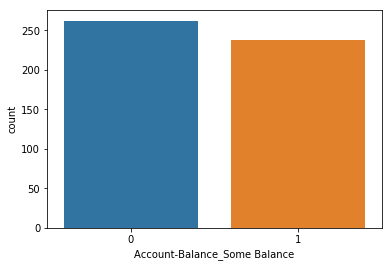

In [16]:
sns.countplot(data = old_applicants_dummies, x = 'Account-Balance_Some Balance')

People with *Account-Balance_Some Balance* is split almost 50/50.

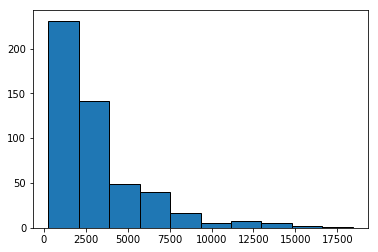

In [17]:
plt.hist(old_applicants_dummies['Credit-Amount'].values, edgecolor="k")
plt.show()


This graph is right skewed, with the majority of individuals having credit amounts of approximately $3750 or less.

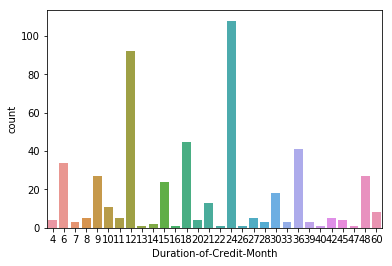

In [18]:
sns.countplot(data = old_applicants_dummies, x = 'Duration-of-Credit-Month')

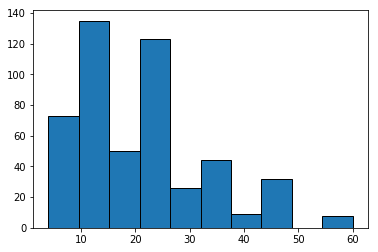

In [19]:
plt.hist(old_applicants_dummies['Duration-of-Credit-Month'].values, edgecolor="k")
plt.show()


There highest counts of *Duration-of-Credit-Month* are around 10-15 months, and 21-26 months.

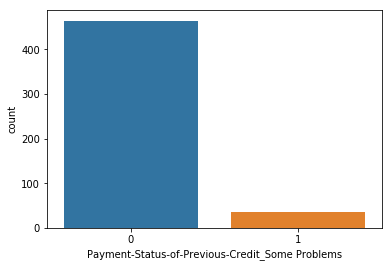

In [20]:
sns.countplot(data = old_applicants_dummies, x = 'Payment-Status-of-Previous-Credit_Some Problems')

There are less people that have some credit problems than there are people who are not labeled with *some problems*.

# Split old_appliants Data 1st Round

In [21]:
# using given random state to obtain the same split
# You should choose 70% to create the Estimation set and 30% to create the Validation set. 
# Set the Random Seed to 1 if you're using Alteryx.
# old_applicants_dummies['Credit-Application-Result_Non-Creditworthy'] 1 = Non-Creditwthy

X = old_applicants_dummies.loc[:, ~old_applicants_dummies.columns.isin(['Credit-Application-Result_Non-Creditworthy'])].copy()
y = old_applicants_dummies['Credit-Application-Result_Non-Creditworthy'].copy()


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, train_size = 0.7)



In [22]:
# impute missing information w/ median value of training set. Age-years is the only feature with missing data.
training_median = X_train.median()
X_train = X_train.fillna(training_median)
X_test = X_test.fillna(training_median)

print(training_median)

Duration-of-Credit-Month                             18.0
Credit-Amount                                      2176.0
Instalment-per-cent                                   3.0
Most-valuable-available-asset                         2.0
Age-years                                            33.0
Type-of-apartment                                     2.0
Occupation                                            1.0
No-of-dependents                                      1.0
Telephone                                             1.0
Foreign-Worker                                        1.0
Account-Balance_Some Balance                          0.0
Payment-Status-of-Previous-Credit_Paid Up             1.0
Payment-Status-of-Previous-Credit_Some Problems       0.0
Purpose_New car                                       0.0
Purpose_Other                                         0.0
Purpose_Used car                                      0.0
Value-Savings-Stocks_None                             1.0
Value-Savings-

In [23]:
X_train.isnull().sum()

Duration-of-Credit-Month                           0
Credit-Amount                                      0
Instalment-per-cent                                0
Most-valuable-available-asset                      0
Age-years                                          0
Type-of-apartment                                  0
Occupation                                         0
No-of-dependents                                   0
Telephone                                          0
Foreign-Worker                                     0
Account-Balance_Some Balance                       0
Payment-Status-of-Previous-Credit_Paid Up          0
Payment-Status-of-Previous-Credit_Some Problems    0
Purpose_New car                                    0
Purpose_Other                                      0
Purpose_Used car                                   0
Value-Savings-Stocks_None                          0
Value-Savings-Stocks_£100-£1000                    0
Length-of-current-employment_4-7 yrs          

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 22)
(150, 22)
(350,)
(150,)


# Removing Features Based On Variance

In [25]:
selector = VarianceThreshold(threshold = 0.0)
selector = selector.fit_transform(X_train)

In [26]:
X_train.var(axis=0).round(3)

Duration-of-Credit-Month                               146.560
Credit-Amount                                      7801794.006
Instalment-per-cent                                      1.248
Most-valuable-available-asset                            1.132
Age-years                                              131.136
Type-of-apartment                                        0.282
Occupation                                               0.000
No-of-dependents                                         0.139
Telephone                                                0.242
Foreign-Worker                                           0.036
Account-Balance_Some Balance                             0.251
Payment-Status-of-Previous-Credit_Paid Up                0.250
Payment-Status-of-Previous-Credit_Some Problems          0.044
Purpose_New car                                          0.076
Purpose_Other                                            0.025
Purpose_Used car                                       

In [27]:
# Notice Concurrent-Credits and Occupation have both been removed from the dataset. There are only 17 columns now.
selector.var(axis=0).round(3)

array([1.46141000e+02, 7.77950317e+06, 1.24500000e+00, 1.12900000e+00,
       1.30762000e+02, 2.81000000e-01, 1.38000000e-01, 2.41000000e-01,
       3.60000000e-02, 2.50000000e-01, 2.49000000e-01, 4.40000000e-02,
       7.60000000e-02, 2.50000000e-02, 1.42000000e-01, 2.40000000e-01,
       2.10000000e-01, 1.88000000e-01, 2.48000000e-01, 6.90000000e-02,
       2.35000000e-01])

In [28]:
# testing df_trfaining_corr dataset for low variance
X_train.var(axis=0)

Duration-of-Credit-Month                           1.465602e+02
Credit-Amount                                      7.801794e+06
Instalment-per-cent                                1.248465e+00
Most-valuable-available-asset                      1.132345e+00
Age-years                                          1.311363e+02
Type-of-apartment                                  2.818256e-01
Occupation                                         0.000000e+00
No-of-dependents                                   1.386492e-01
Telephone                                          2.418011e-01
Foreign-Worker                                     3.586574e-02
Account-Balance_Some Balance                       2.506836e-01
Payment-Status-of-Previous-Credit_Paid Up          2.495375e-01
Payment-Status-of-Previous-Credit_Some Problems    4.374949e-02
Purpose_New car                                    7.620958e-02
Purpose_Other                                      2.512485e-02
Purpose_Used car                        

Occupation is going to dropped from the dataset in the next section due to variance. Interestingly _Concurrent-Credits_ would have also been dropped due to having a variance of zero, but it was dropped from the dataset after running pd.get_dummies() function ealier. Therefore it did not appear in this section. I beleive this is due to it only having one value (i.e. it is dropped naturally because it only has one value _Other Banks/Depts_).

# Split old_appliants Data 2nd Round

In [29]:
# the first split allowed me to look at variance across all features that will be split.
# this second round is allowing me to re-copy the original dataset and drop the attributes I do not want
# in this case I am dropping Occupation due to variance
# there is probably a more elegant way to do this, but I have not figured that out yet

X = old_applicants_dummies.loc[:, ~old_applicants_dummies.columns.isin(['Credit-Application-Result_Non-Creditworthy', 'Occupation'])].copy()
y = old_applicants_dummies['Credit-Application-Result_Non-Creditworthy'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, train_size = 0.7)


In [30]:
# impute missing information w/ median value of training set. Age-years is the only feature with missing data.
training_median = X_train.median()
X_train = X_train.fillna(training_median)
X_test = X_test.fillna(training_median)

print(training_median)

Duration-of-Credit-Month                             18.0
Credit-Amount                                      2176.0
Instalment-per-cent                                   3.0
Most-valuable-available-asset                         2.0
Age-years                                            33.0
Type-of-apartment                                     2.0
No-of-dependents                                      1.0
Telephone                                             1.0
Foreign-Worker                                        1.0
Account-Balance_Some Balance                          0.0
Payment-Status-of-Previous-Credit_Paid Up             1.0
Payment-Status-of-Previous-Credit_Some Problems       0.0
Purpose_New car                                       0.0
Purpose_Other                                         0.0
Purpose_Used car                                      0.0
Value-Savings-Stocks_None                             1.0
Value-Savings-Stocks_£100-£1000                       0.0
Length-of-curr

In [31]:
X_train.isnull().sum()

Duration-of-Credit-Month                           0
Credit-Amount                                      0
Instalment-per-cent                                0
Most-valuable-available-asset                      0
Age-years                                          0
Type-of-apartment                                  0
No-of-dependents                                   0
Telephone                                          0
Foreign-Worker                                     0
Account-Balance_Some Balance                       0
Payment-Status-of-Previous-Credit_Paid Up          0
Payment-Status-of-Previous-Credit_Some Problems    0
Purpose_New car                                    0
Purpose_Other                                      0
Purpose_Used car                                   0
Value-Savings-Stocks_None                          0
Value-Savings-Stocks_£100-£1000                    0
Length-of-current-employment_4-7 yrs               0
Length-of-current-employment_< 1yr            

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 21)
(150, 21)
(350,)
(150,)


# Correlation

In [33]:
corr = X_train.corr()
corr.shape

(21, 21)

In [34]:
corr

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Most-valuable-available-asset,Age-years,Type-of-apartment,No-of-dependents,Telephone,Foreign-Worker,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_New car,Purpose_Other,Purpose_Used car,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,Guarantors_Yes,No-of-Credits-at-this-Bank_More than 1
Duration-of-Credit-Month,1.000000,0.556102,0.111632,0.317129,-0.037375,0.125503,-0.030638,0.172410,-0.167093,-0.070293,-0.047523,0.016521,0.170528,-0.092727,-0.090930,-0.047761,0.022435,0.015145,-0.032705,-0.028300,-0.005266
Credit-Amount,0.556102,1.000000,-0.284339,0.347195,0.117297,0.188269,0.023532,0.338742,-0.018790,-0.097086,-0.069141,0.027221,0.235174,-0.056556,-0.060311,-0.019617,0.017937,0.001965,0.045733,-0.052035,-0.042773
Instalment-per-cent,0.111632,-0.284339,1.000000,0.054601,-0.019726,0.017252,-0.160761,0.015943,-0.143920,0.102144,-0.029041,0.017865,-0.075907,0.052695,-0.117448,-0.026135,0.022352,0.138795,-0.115938,0.056079,0.093895
Most-valuable-available-asset,0.317129,0.347195,0.054601,1.000000,0.155026,0.393022,0.034628,0.246791,-0.167125,0.009312,-0.072169,0.079154,0.140401,-0.123864,-0.020996,0.006586,-0.049287,0.160010,-0.139605,-0.056482,0.020669
Age-years,-0.037375,0.117297,-0.019726,0.155026,1.000000,0.377944,0.151663,0.216776,0.041369,0.106787,-0.198152,0.065241,0.110441,-0.036817,-0.133576,-0.027133,0.048471,0.377782,-0.227806,-0.065150,0.107193
Type-of-apartment,0.125503,0.188269,0.017252,0.393022,0.377944,1.000000,0.166488,0.077775,-0.098121,0.101487,-0.107894,-0.008110,0.082954,-0.054968,-0.077632,0.077011,-0.052926,0.146241,-0.073763,-0.059310,0.062909
No-of-dependents,-0.030638,0.023532,-0.160761,0.034628,0.151663,0.166488,1.000000,-0.070912,0.074996,0.005094,-0.061442,0.086404,0.061165,-0.023857,-0.100778,-0.012548,0.010061,0.095949,-0.102651,0.078865,0.049556
Telephone,0.172410,0.338742,0.015943,0.246791,0.216776,0.077775,-0.070912,1.000000,-0.039208,0.021082,-0.056791,0.014168,0.152699,-0.060709,-0.067049,-0.061762,0.055869,0.057634,-0.064174,-0.100927,-0.006654
Foreign-Worker,-0.167093,-0.018790,-0.143920,-0.167125,0.041369,-0.098121,0.074996,-0.039208,1.000000,-0.073301,-0.058931,-0.042988,-0.059034,0.158995,-0.009163,0.037007,0.003297,0.025472,0.027483,0.117202,-0.028144
Account-Balance_Some Balance,-0.070293,-0.097086,0.102144,0.009312,0.106787,0.101487,0.005094,0.021082,-0.073301,1.000000,-0.096593,-0.161662,0.013800,-0.016195,0.005199,-0.195972,0.225714,0.112003,-0.073554,-0.105723,0.091429


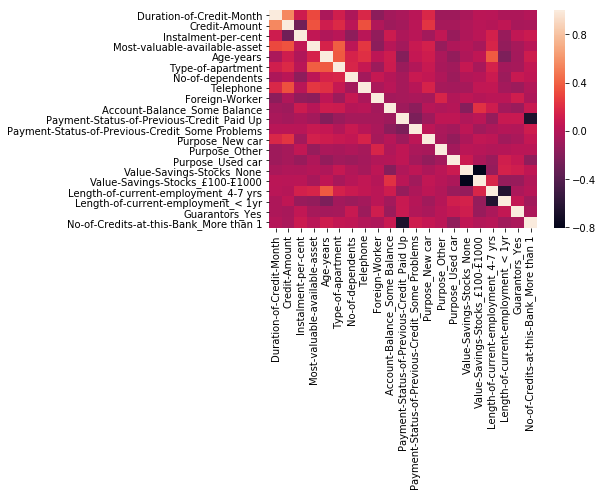

In [35]:
# GENERATE THE HEATMAP
sns.heatmap(corr)

In [36]:
# isolating correlations between features and the target variable
# corr['Credit-Application-Result']

In [37]:
old_applicants.isnull().sum()

Credit-Application-Result             0
Account-Balance                       0
Duration-of-Credit-Month              0
Payment-Status-of-Previous-Credit     0
Purpose                               0
Credit-Amount                         0
Value-Savings-Stocks                  0
Length-of-current-employment          0
Instalment-per-cent                   0
Guarantors                            0
Most-valuable-available-asset         0
Age-years                            12
Concurrent-Credits                    0
Type-of-apartment                     0
No-of-Credits-at-this-Bank            0
Occupation                            0
No-of-dependents                      0
Telephone                             0
Foreign-Worker                        0
dtype: int64

In [38]:
# target variable has already been isolated from features when setting X and y variables
# otherwise I would have used something like the following code to separate the target variable out of the set
# corr['Credit-Application-Result']
# this pairwise correlation exactly matches old_applicants_dummies.corr()
X_train.corrwith(y_train, axis = 0)


Duration-of-Credit-Month                           0.216575
Credit-Amount                                      0.223304
Instalment-per-cent                                0.027147
Most-valuable-available-asset                      0.128530
Age-years                                         -0.048424
Type-of-apartment                                  0.037225
No-of-dependents                                   0.073561
Telephone                                          0.045235
Foreign-Worker                                    -0.017958
Account-Balance_Some Balance                      -0.256463
Payment-Status-of-Previous-Credit_Paid Up          0.016008
Payment-Status-of-Previous-Credit_Some Problems    0.235543
Purpose_New car                                   -0.066924
Purpose_Other                                     -0.058568
Purpose_Used car                                  -0.056013
Value-Savings-Stocks_None                          0.144263
Value-Savings-Stocks_£100-£1000         

In [39]:
# let's look at the absolute values and sort them in order
X_train.corrwith(y_train, axis = 0).abs().sort_values()


Payment-Status-of-Previous-Credit_Paid Up          0.016008
Foreign-Worker                                     0.017958
Guarantors_Yes                                     0.023101
Instalment-per-cent                                0.027147
Type-of-apartment                                  0.037225
No-of-Credits-at-this-Bank_More than 1             0.037496
Telephone                                          0.045235
Age-years                                          0.048424
Purpose_Used car                                   0.056013
Purpose_Other                                      0.058568
Purpose_New car                                    0.066924
No-of-dependents                                   0.073561
Length-of-current-employment_4-7 yrs               0.087165
Most-valuable-available-asset                      0.128530
Value-Savings-Stocks_£100-£1000                    0.133193
Length-of-current-employment_< 1yr                 0.143971
Value-Savings-Stocks_None               

In [40]:
# using pandas to filter features that have ±0.7 correlations.
# there are no strong correlations between the predictor variables and target variable
X_train.corrwith(y_train, axis = 0).abs() > 0.7


Duration-of-Credit-Month                           False
Credit-Amount                                      False
Instalment-per-cent                                False
Most-valuable-available-asset                      False
Age-years                                          False
Type-of-apartment                                  False
No-of-dependents                                   False
Telephone                                          False
Foreign-Worker                                     False
Account-Balance_Some Balance                       False
Payment-Status-of-Previous-Credit_Paid Up          False
Payment-Status-of-Previous-Credit_Some Problems    False
Purpose_New car                                    False
Purpose_Other                                      False
Purpose_Used car                                   False
Value-Savings-Stocks_None                          False
Value-Savings-Stocks_£100-£1000                    False
Length-of-current-employment_4-

In [41]:
# using pandas to filter features that have ±0.2 correlations. 
X_train.corrwith(y_train, axis = 0).abs() > 0.2


Duration-of-Credit-Month                            True
Credit-Amount                                       True
Instalment-per-cent                                False
Most-valuable-available-asset                      False
Age-years                                          False
Type-of-apartment                                  False
No-of-dependents                                   False
Telephone                                          False
Foreign-Worker                                     False
Account-Balance_Some Balance                        True
Payment-Status-of-Previous-Credit_Paid Up          False
Payment-Status-of-Previous-Credit_Some Problems     True
Purpose_New car                                    False
Purpose_Other                                      False
Purpose_Used car                                   False
Value-Savings-Stocks_None                          False
Value-Savings-Stocks_£100-£1000                    False
Length-of-current-employment_4-

As shown in the previous three cells, none of the fieds are highly correlated. In other words, none of the columns have a strong correlation at ±0.7. The first signs indications of correlation occur at 0.3. I set a second filter to test for correlation between features at 0.2, which gave me the top 4 highest correlations between features and the target variable.


In [42]:
# plugging mask into previous pandas filter
# first_correlated_features = X.columns[X.corrwith(y, axis = 0).abs() > 0.7]
first_correlated_features = X_train.columns[X_train.corrwith(y_train, axis = 0).abs() > 0.2]
# first_correlated_features = list(first_correlated_features)
first_correlated_features


Index(['Duration-of-Credit-Month', 'Credit-Amount',
       'Account-Balance_Some Balance',
       'Payment-Status-of-Previous-Credit_Some Problems'],
      dtype='object')

Note:

The data set has been downselected to 6 features:

* Account-Balance_Some Balance
* Credit-Amount
* Duration-of-Credit-Month
* Payment-Status-of-Previous-Credit_Some Problems


# P-Value

We can look at the Pearson correlation coefficients and p-values of the downselected predictor variables by running *pearsonr()* function.

In [43]:
stats.pearsonr(X['Account-Balance_Some Balance'], y)

(-0.316080415357103, 4.606667913072385e-13)

In [44]:
stats.pearsonr(X['Credit-Amount'], y)

(0.20194579161781123, 5.3310815802338685e-06)

In [45]:
stats.pearsonr(X['Duration-of-Credit-Month'], y)

(0.2025036085032149, 5.015063149493572e-06)

In [46]:
stats.pearsonr(X['Payment-Status-of-Previous-Credit_Some Problems'], y)

(0.2535309364742637, 8.970354541038087e-09)

So, I now have five features from the original dataset that are that are most likely to be predictive of the response variable, so I will remove less predictable variables from *X_train* and *X_test*.

In [47]:
X_train = X_train[first_correlated_features]
X_test = X_test[first_correlated_features]


# Logistic Regression

In [48]:
# create classifier as empty box
LRC = LogisticRegression()

In [49]:
# my classifer doesn't now anything about being credit worthy or not
# need to use fit learning algorithm to train the classifier
LRC.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
# let's take the classifier for a spin and make some predictions
pred_LRC = LRC.predict(X_test)
pred_LRC

array([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [75]:
confusion_matrix(y_test, pred_LRC)

array([[93, 10],
       [26, 21]])

In [51]:
# Score it on the test set
# Using the default classification accuracy score
LRC.score(X_test, y_test)

0.76

# Decision Tree

In [52]:
# create classifer... right now it's just an empty box
dectree = tree.DecisionTreeClassifier()


In [53]:
# my classifier doesn't know anything about being credit worthy or not yet
# to train the classifier, I need a learning algorithm
# if a classifier is a box of rules, then the learning algorithm is the procedure that creates the rules
# fit is my classifier, think of it as a synonym for find patterns in data
dectree.fit(X_train, y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
# now that the classifier has been trained let's take it for a spin
pred_dectree = dectree.predict(X_test)
pred_dectree

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [73]:
confusion_matrix(y_test, pred_dectree)

array([[82, 21],
       [24, 23]])

In [55]:
# Score it on the test set
# Using the default classification accuracy score
dectree.score(X_test, y_test)


0.7

In [56]:
creditworthy_results = ["Creditworthy", "Non-Creditworthy"]

In [57]:
list(X.columns)

['Duration-of-Credit-Month',
 'Credit-Amount',
 'Instalment-per-cent',
 'Most-valuable-available-asset',
 'Age-years',
 'Type-of-apartment',
 'No-of-dependents',
 'Telephone',
 'Foreign-Worker',
 'Account-Balance_Some Balance',
 'Payment-Status-of-Previous-Credit_Paid Up',
 'Payment-Status-of-Previous-Credit_Some Problems',
 'Purpose_New car',
 'Purpose_Other',
 'Purpose_Used car',
 'Value-Savings-Stocks_None',
 'Value-Savings-Stocks_£100-£1000',
 'Length-of-current-employment_4-7 yrs',
 'Length-of-current-employment_< 1yr',
 'Guarantors_Yes',
 'No-of-Credits-at-this-Bank_More than 1']

In [58]:
# This output can be visualized

dotfile = StringIO()
tree.export_graphviz(dectree,
                     out_file=dotfile,
                     feature_names=list(X_train.columns),
                     class_names=creditworthy_results,
                     filled=True,
                     rounded=True,
                     impurity=False
                    )
(graph,)=pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("./assets/dtree.png")
graph.write_pdf("./assets/dtree.pdf")

This is a diagram of the visuals I saved to my repository. The diagram provides a visual representation of the decision tree. The nice thing about decision trees is that they are interpretable, and the tree diagram works the same way it would in code (i.e. you know exactly why the classifier makes a decision).

![Displaying the visual I just created:](./assets/dtree.png)


# Boosted Tree (aka Gradient Boosting)


In [59]:
# create classifier... this is an empty box
gbc = GradientBoostingClassifier()

In [60]:
# my classifer doesn't now anything about being credit worthy or not
# use fit algorithm to train the gbc classifier
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [76]:
# take your classifier for a spin, make some predictions
pred_gbc = gbc.predict(X_test)
pred_gbc

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [77]:
confusion_matrix(y_test, pred_gbc)

array([[91, 12],
       [32, 15]])

In [62]:
# Score it on the test set
# Using the default classification accuracy score
gbc.score(X_test, y_test)

0.7066666666666667

# Forest Model (aka Random Forest Model)

In [63]:
# classifier is empty box
rf = RandomForestClassifier()

In [64]:
# classifier doesn't know anything about being credit worthy
# so need to use fit algorithm to train the classifier
# fit(features, target)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [79]:
# take the trained classifier for a spin and make some predictions
pred_rf = rf.predict(X_test)
pred_rf

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [80]:
confusion_matrix(y_test, pred_rf)

array([[94,  9],
       [30, 17]])

In [66]:
# Score it on the test set
# Using the default classification accuracy score
rf.score(X_test, y_test)

0.74

# KNN

In [67]:
# Not a part of this project, but curious how KNN classifier compares to others
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.predict(X_test)
knn.score(X_test, y_test)


0.6133333333333333

# RESOURCES

* ### [project details](https://classroom.udacity.com/nanodegrees/nd008t/parts/54e2103b-5630-497a-bc37-c05d45cda549/modules/12c50013-ad11-4980-88a0-13d474cda9b8/lessons/ee56f886-070e-40ca-bfc8-cab2c5cdde7d/concepts/ac7bf309-3e98-4a2f-ad4e-555905d7cd07)
* ### [rubric](https://review.udacity.com/#!/rubrics/265/view)
* ### [main project folder](https://udacity-travismgillespie.notebooks.azure.com/j/tree)
* ### variance
    * #### [use R-squared to describe variance](https://classroom.udacity.com/nanodegrees/nd008t/parts/9cd2f005-f9b1-4953-ba02-ad65805b2a4a/modules/fc4c1ffe-01f6-4c11-b38b-646ecf1d3c59/lessons/576552b9-a1b4-45be-9428-572331a4e186/concepts/82bfe969-921b-4175-adb5-797e84ba6107): also look into [project 2](https://udacity-travismgillespie.notebooks.azure.com/j/notebooks/project2/Data%20Wrangling.ipynb) diamond catalog to see if I calculated correlation p and r-squared at same time... may have used a corr-matrix
* ### feature selection
    * #### [Packt: select features in machine learning](https://hub.packtpub.com/selecting-statistical-based-features-in-machine-learning-application/)
    * #### [use p-value & correlation to select predictor variable](https://classroom.udacity.com/nanodegrees/nd008t/parts/9cd2f005-f9b1-4953-ba02-ad65805b2a4a/modules/fc4c1ffe-01f6-4c11-b38b-646ecf1d3c59/lessons/576552b9-a1b4-45be-9428-572331a4e186/concepts/82bfe969-921b-4175-adb5-797e84ba6107)
    * #### [p values don’t help in feature selection](https://www.quora.com/How-did-you-use-p-value-for-feature-selection)
    * #### [Feature selection - univariate selection](https://blog.datadive.net/selecting-good-features-part-i-univariate-selection/)
    * #### [predictor variables](https://classroom.udacity.com/nanodegrees/nd008t/parts/9cd2f005-f9b1-4953-ba02-ad65805b2a4a/modules/fc4c1ffe-01f6-4c11-b38b-646ecf1d3c59/lessons/576552b9-a1b4-45be-9428-572331a4e186/concepts/631d190c-8626-4dd7-92df-f5bd96913c48): udacity
    * #### [explanatory variables (aka predictor variables)](https://classroom.udacity.com/nanodegrees/nd008t/parts/9cd2f005-f9b1-4953-ba02-ad65805b2a4a/modules/fc4c1ffe-01f6-4c11-b38b-646ecf1d3c59/lessons/576552b9-a1b4-45be-9428-572331a4e186/concepts/631d190c-8626-4dd7-92df-f5bd96913c48): udacity
    * #### [feature selection ex](https://www.youtube.com/watch?v=hhmsHY2vWY4)
    * #### [feature selection correlation and p-value](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf)
* ### coefficients
    * #### [calculate coefficients](https://classroom.udacity.com/nanodegrees/nd008t/parts/9cd2f005-f9b1-4953-ba02-ad65805b2a4a/modules/fc4c1ffe-01f6-4c11-b38b-646ecf1d3c59/lessons/576552b9-a1b4-45be-9428-572331a4e186/concepts/631d190c-8626-4dd7-92df-f5bd96913c48): watch udacity video
* ### linear regression
    * #### [packt ex](https://www.youtube.com/watch?v=Eqv98w1ukZk): good example of seeds and splitting test set
* ### logistic regression
    * #### [StatQuest](https://www.youtube.com/watch?v=yIYKR4sgzI8)
    * #### [data school ex](https://www.youtube.com/watch?v=RlQuVL6-qe8&index=4&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A)
    * #### [Titanic ex](https://www.youtube.com/watch?v=VCJdg7YBbAQ)
    * #### [logistic regression ex](https://www.youtube.com/watch?v=1nWFHa6K23w)
* ### decision tree
    * #### [iris google developers](https://www.youtube.com/watch?v=tNa99PG8hR8&list=PLOU2XLYxmsIIuiBfYad6rFYQU_jL2ryal&index=2)
* ### boosted tree (aka Gradient boosting)
    * #### [documentation: scikit learn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)
    * #### [gradient boosting ex](https://www.youtube.com/watch?v=gIJHI5jSChM)
    * #### [gradient boosting ex](https://www.youtube.com/watch?v=sRktKszFmSk)
    * #### [gradient boosting ex](https://www.youtube.com/watch?v=X3Wbfb4M33w)
    * #### [gradient boosting ex](https://www.youtube.com/watch?v=2WfKzyi__l4)
    * #### [ada boosting ex](https://www.youtube.com/watch?v=GM3CDQfQ4sw)
    * #### [additional boosting reading](https://en.wikipedia.org/wiki/Gradient_boosting)
* ### forest model (aka random forest model)
    * #### [documentation: scikit learn](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)
    * #### [forest model udacity](https://classroom.udacity.com/nanodegrees/nd008t/parts/54e2103b-5630-497a-bc37-c05d45cda549/modules/12c50013-ad11-4980-88a0-13d474cda9b8/lessons/59e0ee88-1a1e-459d-a79e-53ef74c13e77/concepts/65b13e59-9be3-45f8-a6f3-196369dc3c3d)
    * #### [random forest example](https://www.youtube.com/watch?v=D_2LkhMJcfY)
    
* ### backward elemenation
    * #### [looking up details on SL = 0.05](https://www.kaggle.com/umeshsati54/backward-elimination)
    
* ### misc
    * #### [data school](https://www.youtube.com/watch?v=RlQuVL6-qe8&index=4&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A): 
    * #### [packt](https://www.youtube.com/watch?v=Eqv98w1ukZk): splits data set as projedct instructions describe
    * #### [titanic](https://www.youtube.com/watch?v=VCJdg7YBbAQ): describes creating dummies from dataset
    * #### [iris google developers](https://www.youtube.com/watch?v=tNa99PG8hR8&list=PLOU2XLYxmsIIuiBfYad6rFYQU_jL2ryal&index=2)
    * #### [random_state acts as seed for random number generator](https://medium.com/@contactsunny/how-to-split-your-dataset-to-train-and-test-datasets-using-scikit-learn-e7cf6eb5e0d)
    